In [1]:
import csv
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# DeepMoD stuff
from deepymod import DeepMoD
from deepymod.model.func_approx import NN, Siren
from deepymod.model.library import Library1D
from deepymod.model.constraint import LeastSquares
from deepymod.model.sparse_estimators import Clustering, Threshold, PDEFIND
from deepymod.training import train
from deepymod.analysis import load_tensorboard
from derivatives import library, finite_diff, spline_diff
from sklearn.linear_model import LassoCV

from deepymod.training.sparsity_scheduler import TrainTestPeriodic
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
# Settings for reproducibility
np.random.seed(42)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Figure paper

In [2]:
delta_V[lower_lim:upper_lim,:].T

NameError: name 'delta_V' is not defined

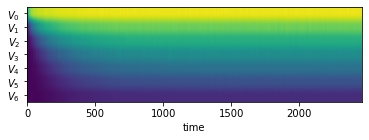

In [3]:
delta_V = np.load('7_elements.npy')
upper_lim = 3000 
lower_lim = 540 

plt.figure(figsize=(6, 6))
plt.imshow(delta_V[lower_lim:upper_lim,:].T,aspect=100)
plt.yticks([0,1,2,3,4,5,6],['$V_0$','$V_1$','$V_2$','$V_3$','$V_4$','$V_5$','$V_6$'])
plt.xlabel('time')
plt.savefig('cable_eq_2.pdf')

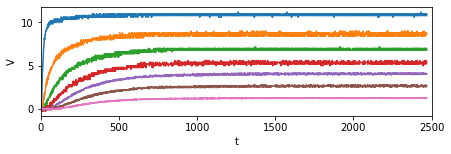

In [69]:
delta_V = np.load('7_elements.npy')
upper_lim = 3000 
lower_lim = 530 

plt.figure(figsize=(7, 2))
plt.plot(delta_V[lower_lim:upper_lim,0].T)
plt.plot(delta_V[lower_lim:upper_lim,1].T)
plt.plot(delta_V[lower_lim:upper_lim,2].T)
plt.plot(delta_V[lower_lim:upper_lim,3].T)
plt.plot(delta_V[lower_lim:upper_lim,4].T)
plt.plot(delta_V[lower_lim:upper_lim,5].T)
plt.plot(delta_V[lower_lim:upper_lim,6].T)
#plt.yticks([0,1,2,3,4,5,6],['$V_0$','$V_1$','$V_2$','$V_3$','$V_4$','$V_5$','$V_6$'])
plt.ylabel('V')
plt.xlabel('t')
plt.xlim(0,2500)
plt.savefig('cable_eq_1.pdf')

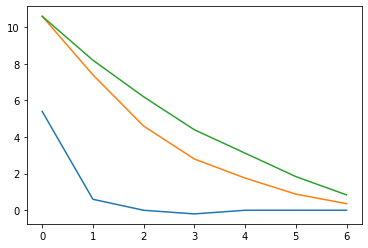

In [11]:
plt.plot(delta_V[lower_lim+2,:])
plt.plot(delta_V[lower_lim+200,:])
plt.plot(delta_V[lower_lim+400,:])

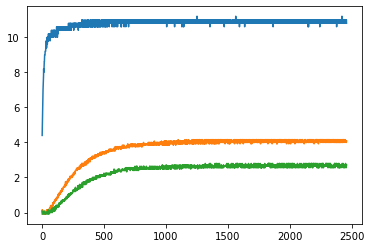

In [7]:
plt.plot(delta_V[lower_lim:upper_lim,0])
plt.plot(delta_V[lower_lim:upper_lim,4])
plt.plot(delta_V[lower_lim:upper_lim,])

## Loop finite difference

In [59]:
exp_list = [13,11,9,7,5]
xi_list = []
threshold = 0.2
for i in exp_list:
    delta_V = np.load(str(i)+'_elements.npy')
    output_data = delta_V[lower_lim:upper_lim,:]
    x = np.linspace(0, 1, output_data.shape[1])
    t = np.linspace(0, 1, output_data.shape[0])
    y = output_data/np.max(output_data)
    print('(time, space):', y.shape)

    bor = 2

    dt = finite_diff(y,t,order=1,axis=1)[bor:-bor,bor:-bor].flatten()
    u = y[bor:-bor,bor:-bor].flatten()
    u_x = finite_diff(y,x,order=1,axis=0)[bor:-bor,bor:-bor].flatten()
    u_xx = finite_diff(y,x,order=2,axis=0)[bor:-bor,bor:-bor].flatten()

    theta = np.transpose((np.ones_like(u), u_x, u_xx, u,u*u_x, u*u_xx))
    theta = theta/np.linalg.norm(theta,axis=0, keepdims=True)
    dt = dt/np.linalg.norm(dt)

    reg = LassoCV(fit_intercept=False, cv=10)
    xi = reg.fit(theta, dt).coef_[:, None].flatten()
    xi[np.abs(xi) < threshold] = 0
    xi_list.append(xi)

(time, space): (2470, 13)
(time, space): (2470, 11)
(time, space): (2470, 9)
(time, space): (2470, 7)
(time, space): (2470, 5)


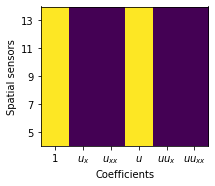

In [62]:
plt.figure(figsize=(3, 3))
plt.imshow(np.abs(np.array(xi_list).reshape(5,6)),vmin=0, vmax=0.01)
plt.xlabel('Coefficients')
plt.ylabel('Spatial sensors')
plt.yticks([0,1,2,3,4],['13', '11', '9', '7','5'])
plt.xticks([0,1,2,3,4,5],[1,'$u_x$','$u_{xx}$','$u$','$u u_x$','$u u_{xx}$' ])
plt.savefig('cable_eq_FD.pdf')
#plt.show()


In [ ]:
exp_list = [13,11,9,7,5]
xi_list = []
threshold = 0.2
for i in exp_list:
    delta_V = np.load(str(i)+'_elements.npy')
    output_data = delta_V[lower_lim:upper_lim,:]
    x = np.linspace(0, 1, output_data.shape[1])
    t = np.linspace(0, 1, output_data.shape[0])
    y = output_data/np.max(output_data)
    print('(time, space):', y.shape)

    bor = 2

    dt = finite_diff(y,t,order=1,axis=1)[bor:-bor,bor:-bor].flatten()
    u = y[bor:-bor,bor:-bor].flatten()
    u_x = finite_diff(y,x,order=1,axis=0)[bor:-bor,bor:-bor].flatten()
    u_xx = finite_diff(y,x,order=2,axis=0)[bor:-bor,bor:-bor].flatten()

    theta = np.transpose((np.ones_like(u), u_x, u_xx, u,u*u_x, u*u_xx))
    theta = theta/np.linalg.norm(theta,axis=0, keepdims=True)
    dt = dt/np.linalg.norm(dt)

    reg = LassoCV(fit_intercept=False, cv=10)
    xi = reg.fit(theta, dt).coef_[:, None].flatten()
    xi[np.abs(xi) < threshold] = 0
    xi_list.append(xi)

## Loop spline

In [56]:
def fit_spline(x, u, k=5, s=0.0):
    spline = np.stack([UnivariateSpline(x, u[frame, :], k=k, s=s) for frame in np.arange(u.shape[0])], axis=0)
    return spline


In [46]:
output_data.shape

(2470, 5)

In [52]:
exp_list = [13,11,9,7,5]
xi_list = []
threshold = 0.2
delta_V = np.load(str(9)+'_elements.npy')
output_data = delta_V[lower_lim:upper_lim,:].T
output_data = output_data/np.max(output_data)
t = np.linspace(0, 1, output_data.shape[1])
x = np.linspace(0, 1, output_data.shape[0])

In [53]:
output_data.shape

(9, 2470)

In [54]:
x.shape

(9,)

In [55]:
t.shape

(2470,)

In [51]:

dt, theta = library(output_data, x, t, deriv_kind='spline',poly_order=1,deriv_order=2, s=0.001, k=3)
reg = LassoCV(fit_intercept=False, cv=10)
xi = reg.fit(theta, dt).coef_[:, None].flatten()
xi[np.abs(xi) < threshold] = 0
print(xi)

ValueError: x and y should have a same length

In [49]:
output_data.shape

(9, 2470)

In [57]:
exp_list = [13,11,9,7,5]
xi_list = []
for i in exp_list:
    delta_V = np.load(str(i)+'_elements.npy')
    output_data = delta_V[lower_lim:upper_lim,:]
    output_data = output_data/np.max(output_data)
    t = np.linspace(0, 1, output_data.shape[0])
    x = np.linspace(0, 1, output_data.shape[1])
    
    dt, theta = library(output_data, x, t, deriv_kind='spline',poly_order=1,deriv_order=2, s=0.01, k=4)
    reg = LassoCV(fit_intercept=False, cv=25)
    xi = reg.fit(theta, dt).coef_[:, None].flatten()
    xi[np.abs(xi) < threshold] = 0
    xi_list.append(xi)

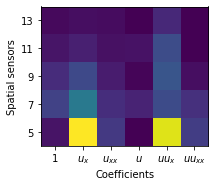

In [58]:
plt.figure(figsize=(3, 3))
plt.imshow(np.abs(np.array(xi_list).reshape(5,6)))
plt.xlabel('Coefficients')
plt.ylabel('Spatial sensors')
plt.yticks([0,1,2,3,4],['13', '11', '9', '7','5'])
plt.xticks([0,1,2,3,4,5],[1,'$u_x$','$u_{xx}$','$u$','$u u_x$','$u u_{xx}$' ])
plt.show()

In [41]:
xi_list[4]

array([ -0.70991834, -10.26373931,   3.24885457,   0.        ,
        10.63107624,  -2.70263569])

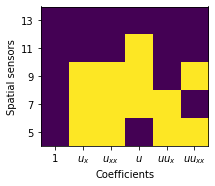

In [43]:
plt.figure(figsize=(3, 3))
plt.imshow(np.abs(np.array(xi_list).reshape(5,6)), vmax=0.01)
plt.xlabel('Coefficients')
plt.ylabel('Spatial sensors')
plt.yticks([0,1,2,3,4],['13', '11', '9', '7','5'])
plt.xticks([0,1,2,3,4,5],[1,'$u_x$','$u_{xx}$','$u$','$u u_x$','$u u_{xx}$' ])
plt.show()

In [164]:
print(np.linalg.lstsq(theta, dt)[0])

[[ -0.65314909]
 [-11.57820604]
 [  1.69135583]
 [  0.13500985]
 [ 11.00717392]
 [ -1.86572213]]


<ipython-input-164-74ec5f8d5fbd>:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  print(np.linalg.lstsq(theta, dt)[0])


## Results DeepMoD

In [24]:
df = load_tensorboard('runs/13/')
xi_13 = np.abs(np.array([df.loc[:,'coeffs_output_0_coeff_'+str(i)] for i in np.arange(0,6)]))[:,-1]
df = load_tensorboard('runs/11/')
xi_11 = np.abs(np.array([df.loc[:,'coeffs_output_0_coeff_'+str(i)] for i in np.arange(0,6)]))[:,-1]
df = load_tensorboard('runs/9/')
xi_9 = np.abs(np.array([df.loc[:,'coeffs_output_0_coeff_'+str(i)] for i in np.arange(0,6)]))[:,-1]
df = load_tensorboard('runs/7/')
xi_7 = np.abs(np.array([df.loc[:,'coeffs_output_0_coeff_'+str(i)] for i in np.arange(0,6)]))[:,-1]
df = load_tensorboard('runs/5c/')
xi_5 = np.abs(np.array([df.loc[:,'coeffs_output_0_coeff_'+str(i)] for i in np.arange(0,6)]))[:,-1]

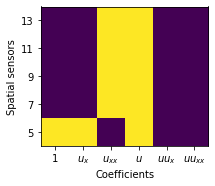

In [25]:
plt.figure(figsize=(3, 3))
plt.imshow(np.array((xi_13,xi_11,xi_9,xi_7,xi_5)),vmin=0, vmax=0.1)
plt.xlabel('Coefficients')
plt.ylabel('Spatial sensors')
plt.yticks([0,1,2,3,4],['13', '11', '9', '7','5'])
plt.xticks([0,1,2,3,4,5],[1,'$u_x$','$u_{xx}$','$u$','$u u_x$','$u u_{xx}$' ])
plt.savefig('cable_eq_1.pdf')